In [1]:
import numpy as np
import torch
import torch.nn as nn
from timm.models import create_model
from vit_models import VisionTransformer, VisionTransformerDistilled
import lightning as L
from lightning import Trainer
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from lightning.pytorch.callbacks import ModelCheckpoint
from loss import DistillationLoss
import random

In [2]:
parent_custom_config = {
        "img_size": 224,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
        "n_classes": 200
}

In [3]:
model_custom = VisionTransformer(**parent_custom_config)
model_custom.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=200, bia

In [4]:
resize = transforms.Resize(size=(224, 224), antialias=True)
compose = transforms.Compose([
resize,
transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=compose)
val_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=compose)

train_labels = {}
for mapping in open('/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/words.txt','r').readlines():
    maps = mapping.replace('\n','').split('\t')
    train_labels[maps[0]] = maps[1]

def train_map_labels(dataset):
    class_labels = {}
    for ind in range(0, 100000, 500):
        class_name = dataset.imgs[ind][0].split('/')[-1].split('_')[0]
        class_label = dataset[ind][1]
        class_labels[class_label] = class_name
    return class_labels

# for ind, (k,v) in enumerate(train_labels.items()):
#     print(k,v)
#     if ind > 10:
#         break

train_class_labels = train_map_labels(train_dataset)

for ind, (k, v) in enumerate(train_class_labels.items()):
    print(k, v, train_labels[v])
    if ind == 10:
        break
print("\n\n")        
for i in range(0, 10000, 50):
    class_label = val_dataset.imgs[i][0].split('/')[-3]
    print(val_dataset[i][1], class_label, train_labels[class_label])
    if i == 500:
        break

0 n01443537 goldfish, Carassius auratus
1 n01629819 European fire salamander, Salamandra salamandra
2 n01641577 bullfrog, Rana catesbeiana
3 n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
4 n01698640 American alligator, Alligator mississipiensis
5 n01742172 boa constrictor, Constrictor constrictor
6 n01768244 trilobite
7 n01770393 scorpion
8 n01774384 black widow, Latrodectus mactans
9 n01774750 tarantula
10 n01784675 centipede



0 n01443537 goldfish, Carassius auratus
1 n01629819 European fire salamander, Salamandra salamandra
2 n01641577 bullfrog, Rana catesbeiana
3 n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
4 n01698640 American alligator, Alligator mississipiensis
5 n01742172 boa constrictor, Constrictor constrictor
6 n01768244 trilobite
7 n01770393 scorpion
8 n01774384 black widow, Latrodectus mactans
9 n01774750 tarantula
10 n01784675 centipede


In [5]:
batch_size = 300
lr = 1e-5
class VisionTransformerWrapper(L.LightningModule):
    
    def __init__(self, model):
        super(VisionTransformerWrapper, self).__init__()
        self.model = model
        self.accuracy = Accuracy(task="multiclass", num_classes=200)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="train", on_epoch=False, on_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="val", on_epoch=True, on_step=False)
        
    def _common_step(self, batch, batch_idx, log_name="", on_epoch=True,  on_step=True):
        images, labels = batch
        outputs = self(images)
        
        loss = F.cross_entropy(outputs, labels)
        self.log(f"{log_name}_loss", loss, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        self.accuracy(outputs, labels)
        
        self.log(f"{log_name}_acc", self.accuracy, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr)
        
    def train_dataloader(self):
        train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=compose)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=11, persistent_workers=True)
        return train_loader

    def val_dataloader(self):
        val_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=compose)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=11, persistent_workers=True)
        return val_loader
    

parent_model = VisionTransformerWrapper.load_from_checkpoint(os.getcwd()+"/fine_tune_models/"+'best-model.ckpt', model=model_custom)

97 val desk


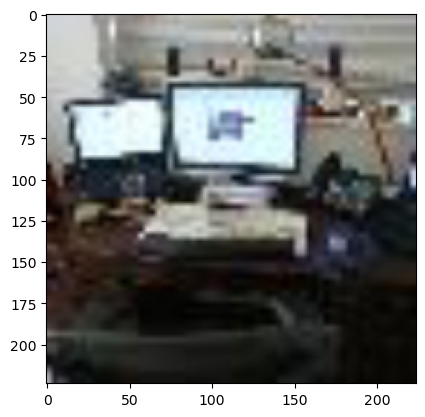

In [6]:
index = random.randint(0,10000)
plt.imshow(torch.permute(val_dataset[index][0], (1,2,0)).numpy())
label_class = val_dataset.imgs[index][0].split('/')[-1].split('_')[0]
label_num = val_dataset[index][1]
print(label_num, label_class, train_labels[train_class_labels[label_num]])

In [7]:
parent_model.cpu().eval()
logits = parent_model(resize(val_dataset[index][0].unsqueeze(0).to(torch.float32)))
probs = torch.nn.functional.softmax(logits, dim=-1)
top_probs, top_ixs = probs[0].topk(5)
# print(f"\n{image}")
for _, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = train_labels[train_class_labels[ix]]
    print(f"{ix_}: {cls:<45} --- {prob:.4f}")
    
probs = torch.argmax(logits, dim=-1)
print(f"{train_labels[train_class_labels[probs.item()]]}")

97: desk                                          --- 0.9911
92: computer keyboard, keypad                     --- 0.0079
110: iPod                                          --- 0.0001
176: comic book                                    --- 0.0000
101: flagpole, flagstaff                           --- 0.0000
desk


In [8]:
student_custom_config = {
        "img_size": 224,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 192,
        "depth": 8,
        "n_heads": 3,
        "qkv_bias": True,
        "mlp_ratio": 4,
        "n_classes": 200
}
# student_model = VisionTransformerWrapper(VisionTransformer(**student_custom_config))
# student_model =  VisionTransformerWrapper.load_from_checkpoint(os.getcwd()+"/distilled_models/"+"imagnet-tiny-epoch=00-val_acc=0.04.ckpt",
#                                                                model=VisionTransformer(**student_custom_config))

In [9]:
checkpoint_callback = ModelCheckpoint(
    dirpath=os.getcwd()+"/distilled_models/",
    save_top_k=2,
    verbose=True,
    monitor='val_acc',
    every_n_train_steps=30,
    mode='max',
    filename='imagnet-tiny-{epoch:02d}-{val_acc:.2f}',
    save_on_train_epoch_end=True
)

In [10]:
# trainer = Trainer(max_epochs=1,
#                   log_every_n_steps=11, 
#                   val_check_interval=30,
#                   limit_train_batches=0.25,
#                   callbacks=[checkpoint_callback])
# student_model.train()
# trainer.fit(student_model)

In [16]:
batch_size = 100
lr = 1e-3
class VisionTransformerDistilledWrapper(L.LightningModule):
    
    def __init__(self, model, loss):
        super(VisionTransformerDistilledWrapper, self).__init__()
        self.model = model
        self.loss = loss
        self.accuracy = Accuracy(task="multiclass", num_classes=200)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="train", on_epoch=False, on_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="val", on_epoch=True, on_step=False)
        
    def _common_step(self, batch, batch_idx, log_name="", on_epoch=True,  on_step=True):
        images, labels = batch
        
        outputs = self(images)
            
        loss = self.loss(images, outputs, labels)
        
        self.log(f"{log_name}_loss", loss, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        outputs_cls, _ = outputs
        
        self.accuracy(outputs_cls, labels)
        
        self.log(f"{log_name}_acc", self.accuracy, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=1e-3, lr=lr)
        
    def train_dataloader(self):
        train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=compose)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=11, persistent_workers=True)
        return train_loader

    def val_dataloader(self):
        val_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=compose)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=11, persistent_workers=True)
        return val_loader
    

In [17]:
parent_model.eval()

for param in parent_model.parameters():
    param.requires_grad = False
    
distlilled_loss = DistillationLoss(F.cross_entropy, parent_model, 'soft', 0.5, 1)

distilled_model = VisionTransformerDistilledWrapper(model=VisionTransformerDistilled(**student_custom_config), loss=distlilled_loss)

trainer = Trainer(max_epochs=1,
                  log_every_n_steps=11,
                  val_check_interval=100,
                  # limit_val_batches=20,
                  callbacks=[checkpoint_callback])

trainer.fit(distilled_model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | VisionTransformerDistilled | 3.8 M 
1 | loss     | DistillationLoss           | 86.0 M
2 | accuracy | MulticlassAccuracy         | 0     
--------------------------------------------------------
3.8 M     Trainable params
86.0 M    Non-trainable params
89.8 M    Total params
359.100   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 30: 'val_acc' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 90: 'val_acc' reached 0.00560 (best 0.00560), saving model to '/Users/ykamoji/Documents/Learning/ViT/KnowledgeDistillation/distilled_models/imagnet-tiny-epoch=00-val_acc=0.01.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_acc' reached 0.00480 (best 0.00560), saving model to '/Users/ykamoji/Documents/Learning/ViT/KnowledgeDistillation/distilled_models/imagnet-tiny-epoch=00-val_acc=0.00.ckpt' as top 2
Epoch 0, global step 150: 'val_acc' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 180: 'val_acc' reached 0.00600 (best 0.00600), saving model to '/Users/ykamoji/Documents/Learning/ViT/KnowledgeDistillation/distilled_models/imagnet-tiny-epoch=00-val_acc=0.01-v1.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
# torch.mps.empty_cache()